In [36]:
""" A notebook to evaluate GNN explainer performance by calculating Comprehensiveness and Sufficiency 
    as defined in "BAGEL: A Benchmark for Assessing Graph Neural Network Explanations", by Rathee et al. (2022). 

    Model training and explanation generation adapted from the original MolRep code by Tim Stols.
"""

In [36]:
# Converted by Tim Stols
# python Explainer_Experiments.py --model_name CMPNN \
#                                                        --attribution_name GradInput \
#                                                        --data_path ../MolRep/Datasets/Metabolism/admet2.1_rlm_merge.csv \
#                                                        --dataset_name RLM \
#                                                        --smiles_col COMPOUND_SMILES \
#                                                        --target_col CLF_LABEL \
#                                                        --task_type Multi-Classification \
#                                                        --multiclass_num_classes 3 \
#                                                        --output_dir ../Outputs

In [37]:
import gc
import os

from datetime import datetime
from pathlib import Path

from MolRep.Models.graph_based import CMPNN

# output directory for trained model and explanations
OUTPUT_DIR = f'../Outputs/Experiment' # /{datetime.now().strftime("%Y%m%d_%H%M%S")}
# OUTPUT_DIR = '../Outputs' # original output path, overwrites results

# output the explanations (optionally model) here
output_dir = Path(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATASET = 'Benzene'
# DATASET = '3MR'

# GNN
MODEL = 'CMPNN' # Options:  ['MPNN', 'DMPNN', 'CMPNN', 'GIN', 'ECC', 'GAT', 'DGCNN', 'DiffPool', 'GraphSAGE', 'GraphNet']

# use specified model, else train a new one
MODELPATH = None
MODELPATH = '../Outputs/Experiment/CMPNN_Benzene_explainer/CMPNN_1_epoch.pt' # using this model because it has non-zero F1 score
# MODELPATH = '../Models/CMPNN_3MR_explainer_20240519_143138.pt'

if MODELPATH is None:
    MODELPATH = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", f"{MODEL}.pt")

# explainers used on the trained model, overwritten down below for testing purposes
ATTRIBUTIONS = ['IG', 'Random'] # Options: IG CAM MCTS GradInput GradCAM RandomBaseline # this says RandomBaseLine but code expects 'Random'

DATAPATH = '../Datasets/XAI/Benzene/benzene_smiles.csv'
# DATAPATH = '../DataSets/3MR/toy_label_mw350.csv'
SMILESCOL = 'SMILES'
TARGETCOL = 'label'
# TARGETCOL = 'label_full' # for 3MR, on my machine the functions targets the wrong label, even if the offending column is deleted

ATTRIBUTIONPATH = '../Datasets/XAI/Benzene/attributions.npz'
# ATTRIBUTIONPATH = '../DataSets/3MR/attributions.npz'


TASKTYPE = 'Classification' # Can be 'Multi-Classification', 'Classification', 'Regression'
MULTICLASS_NUM_CLASSES = 2 # Can be 3
TESTING = True
SPLITTYPE = 'defined' # Can be 'random', 'scaffold', or other defined for dataset


In [38]:
import rdkit.Chem
from MolRep.Utils.logger import Logger
from MolRep.Explainer.explainerExperiments import ExplainerExperiments
from MolRep.Explainer.explainerDataWrapper import ExplainerDatasetWrapper
from MolRep.Utils.config_from_dict import Grid, Config, DatasetConfig
from pathlib import Path
import os
from numba.cuda import args

# torch.set_num_threads(1)

# set up the model
data_stats = {
            'name': DATASET,
            'path': DATAPATH,
            'smiles_column': SMILESCOL,
            'target_columns': [TARGETCOL],
            'attribution_path': ATTRIBUTIONPATH,
            'task_type': TASKTYPE,
            'multiclass_num_classes': MULTICLASS_NUM_CLASSES,
            'metric_type': 'rmse' if TASKTYPE == 'Regression' else ['acc', 'auc', 'f1', 'precision', 'recall'],
            'split_type': SPLITTYPE
}

if TESTING:
    data_stats['additional_info'] = {"splits":'SPLIT'}
    
# output for vector groups
data_dir = Path('../MolRep/Data')
split_dir = Path('../MolRep/Splits')
os.makedirs(data_dir, exist_ok=True)
os.makedirs(split_dir, exist_ok=True)

In [39]:
config_file = '../MolRep/Configs/config_{}.yml'.format(MODEL)
model_configurations = Grid(config_file)
model_configuration = Config(**model_configurations[0])
dataset_configuration = DatasetConfig(DATASET, data_dict=data_stats)

CMPNN
{'GIN': <class 'MolRep.Models.graph_based.GIN.GIN'>, 'ECC': <class 'MolRep.Models.graph_based.ECC.ECC'>, 'DGCNN': <class 'MolRep.Models.graph_based.DGCNN.DGCNN'>, 'DiffPool': <class 'MolRep.Models.graph_based.DiffPool.DiffPool'>, 'GraphSAGE': <class 'MolRep.Models.graph_based.GraphSAGE.GraphSAGE'>, 'GAT': <class 'MolRep.Models.graph_based.GAT.GAT'>, 'GraphNet': <class 'MolRep.Models.graph_based.GraphNet.GraphNet'>, 'MPNN': <class 'MolRep.Models.graph_based.MPNN.MPNN'>, 'CMPNN': <class 'MolRep.Models.graph_based.CMPNN.CMPNN'>, 'DMPNN': <class 'MolRep.Models.graph_based.DMPNN.DMPNN'>, 'MAT': <class 'MolRep.Models.sequence_based.MAT.MAT'>, 'CoMPT': <class 'MolRep.Models.sequence_based.CoMPT.CoMPT'>, 'BiLSTM': <class 'MolRep.Models.sequence_based.BiLSTM.BiLSTM'>, 'SALSTM': <class 'MolRep.Models.sequence_based.SALSTM.SALSTM'>, 'Transformer': <class 'MolRep.Models.sequence_based.Transformer.Transformer'>, 'VAE': <class 'MolRep.Models.unsupervised_based.VAE.VAE'>, 'RandomForest': <class

In [40]:
# export path: model + dataset name
exp_path = os.path.join(output_dir, f'{model_configuration.exp_name}_{dataset_configuration.exp_name}_explainer')

# dataset_config: configuration of the model
# model_name: name of the model
# split_dir: path to defined splits of the dataset
# features_dir: path to data directory
dataset = ExplainerDatasetWrapper(dataset_config=dataset_configuration,
                                  model_name=model_configuration.exp_name,
                                  split_dir=split_dir, features_dir=data_dir)

# set up the experiment
explainer_experiment = ExplainerExperiments(model_configuration, dataset_configuration, exp_path)

Moving model to cuda


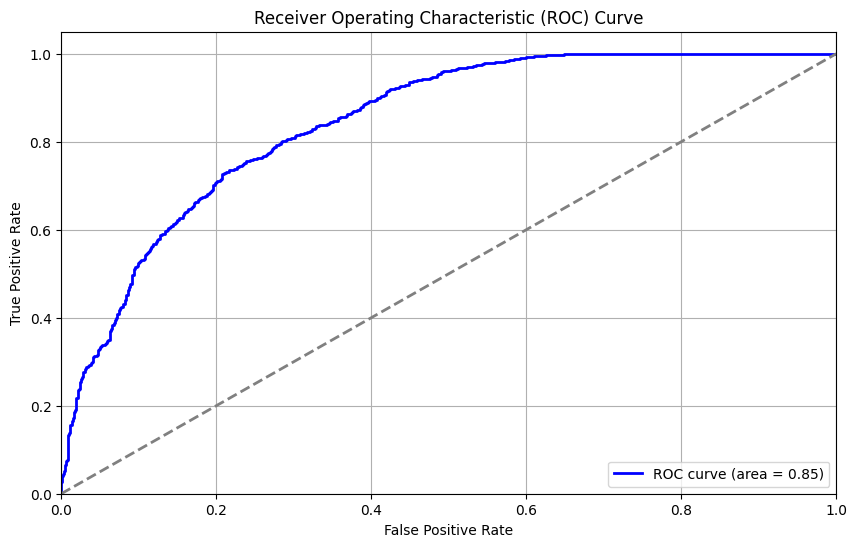

(2400, 3)
..\Outputs\Experiment\CMPNN_Benzene_explainer\CMPNN_explained_by_IG_oof.csv


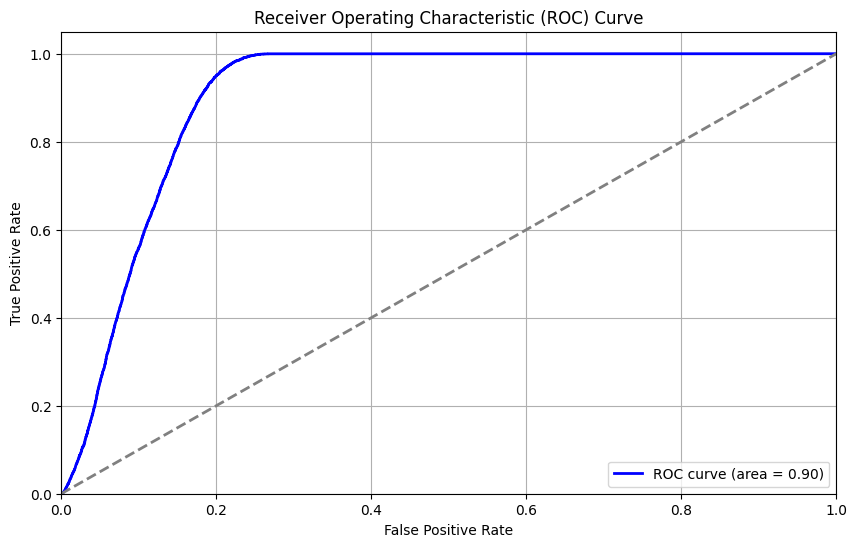

Moving model to cuda


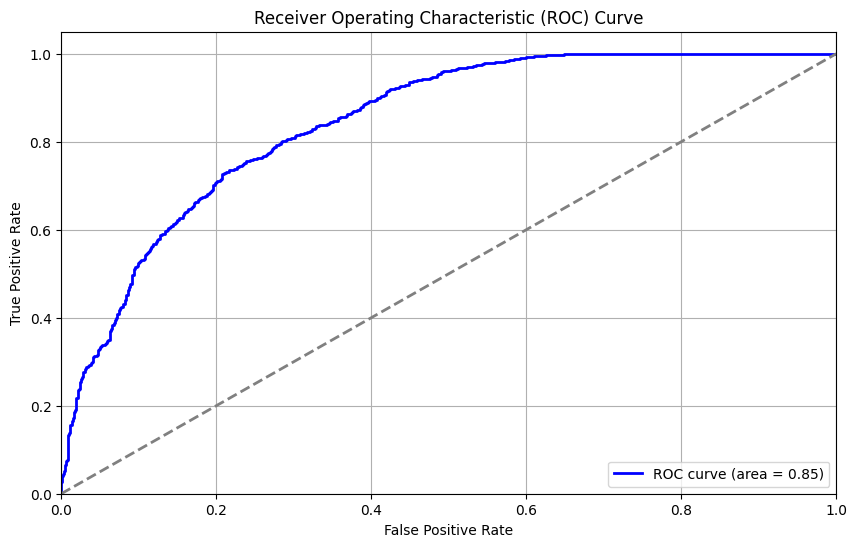

(2400, 3)
..\Outputs\Experiment\CMPNN_Benzene_explainer\CMPNN_explained_by_CAM_oof.csv


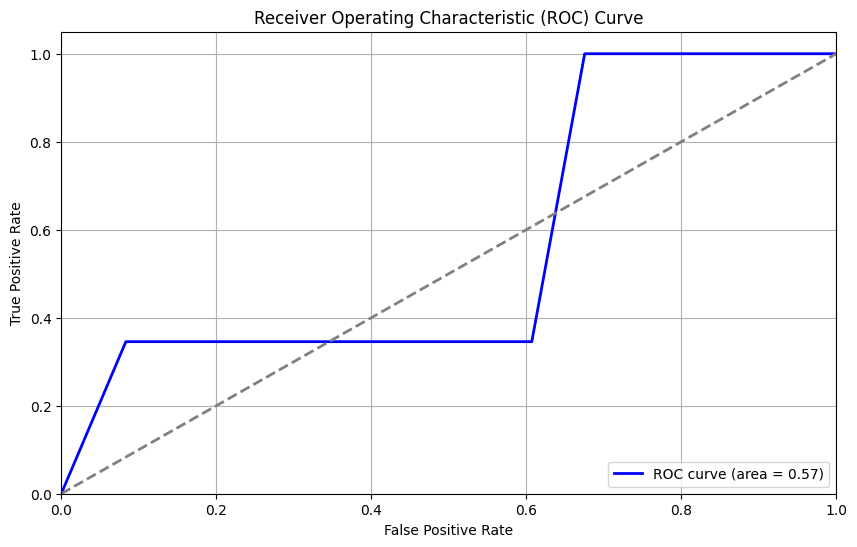

Moving model to cuda


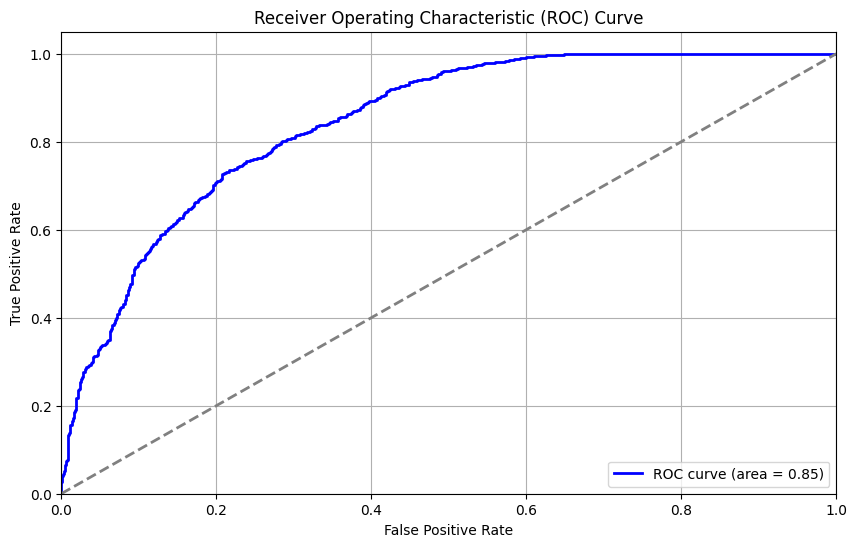

(2400, 3)
..\Outputs\Experiment\CMPNN_Benzene_explainer\CMPNN_explained_by_GradCAM_oof.csv


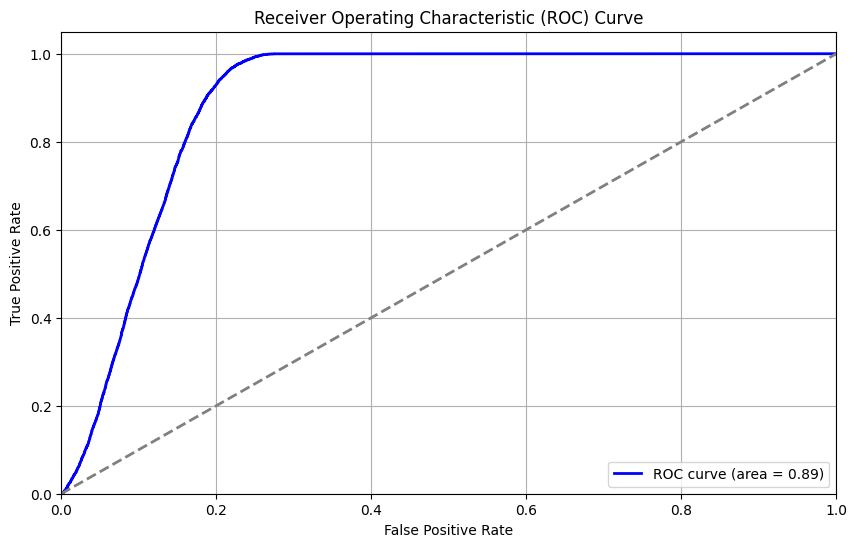

Moving model to cuda


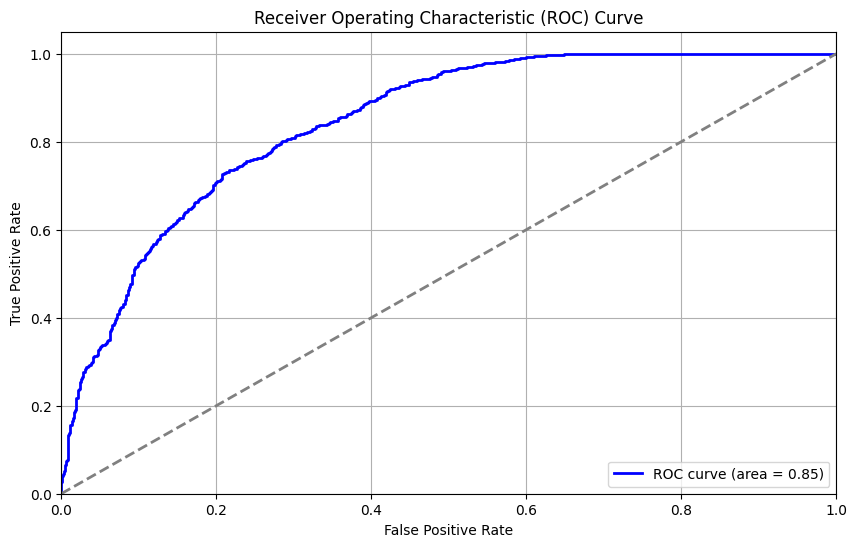

(2400, 3)
..\Outputs\Experiment\CMPNN_Benzene_explainer\CMPNN_explained_by_Random_oof.csv


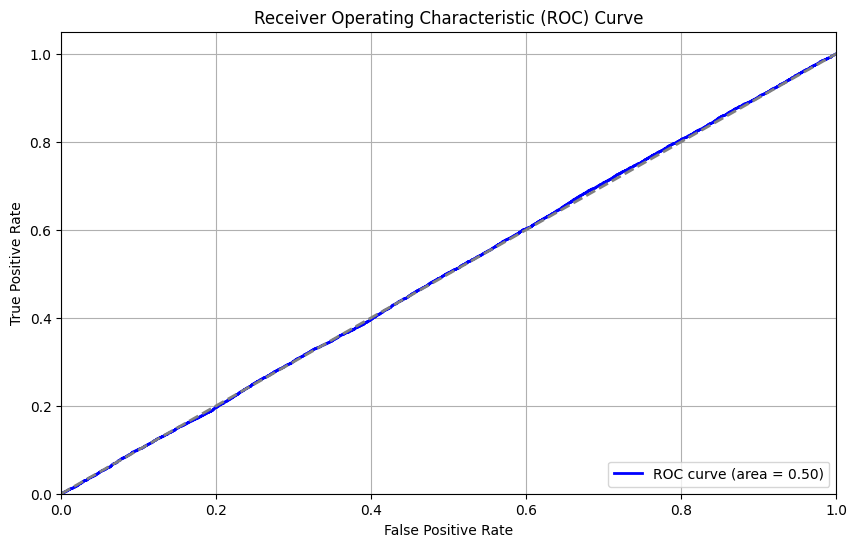

In [41]:
import pandas as pd
import torch

# to load a model from a file without having used it, need to instantiate the model
# model = CMPNN(model_configuration)
# state_dict = torch.load(MODELPATH)
# model.load_state_dict(state_dict)

# Options: IG CAM MCTS GradInput GradCAM RandomBaseline # says RandomBaseLine but code expects 'Random'
ATTRIBUTIONS = ['IG', 'CAM', 'GradCAM', 'Random']

# store explainer results
atom_importances = []
explainer_accuracies = []

# generate explanations for each explainer
for ATTRIBUTION in ATTRIBUTIONS:
    LOGGER_BASE = os.path.join(OUTPUT_DIR, "Logger", f"{DATASET}_explainer")
    logger = Logger(str(os.path.join(LOGGER_BASE, f"{MODEL}_{DATASET}_explainer_by_{ATTRIBUTION}.log")), mode='a')
    
    # define path for graphics
    svg_dir = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs")
    os.makedirs(svg_dir, exist_ok=True)

    ### comment out if a model exists and want to use it with all models, else trains a new one for each ###
    # explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})

    ## if model doesn't exist, train a new one
    # if not os.path.exists(MODELPATH):
    #     explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})
    
    # generate attributions; bond_importance is None in all the tests I ran
    results, atom_importance, bond_importance = explainer_experiment.molecule_importance(dataset=dataset, attribution=ATTRIBUTION, logger=logger, other={'model_path':MODELPATH}, testing=TESTING)
    
    if DATASET in ['hERG', 'CYP3A4']:
        attribution_results, opt_threshold = explainer_experiment.evaluate_cliffs(dataset, atom_importance, bond_importance)
    else:
        binary = True if ATTRIBUTION == 'MCTS' else False
        #TODO "not working, because ATTRIBUTIONPATH is not set and attributions are not saved"
        attribution_results, opt_threshold = explainer_experiment.evaluate_attributions(dataset, atom_importance, bond_importance, binary=binary)
     
    # creates visualizations from the datasets and outputs them to svg_dir
    explainer_experiment.visualization(dataset, atom_importance, bond_importance, svg_dir=svg_dir, testing=TESTING)

    # write the results, atom importances to a file
    df = pd.DataFrame(
        {'SMILES': dataset.get_smiles_list(), 'Atom_importance': atom_importance, 'Bond_importance':bond_importance}
    )
    df.to_csv(os.path.join(svg_dir, "importances.csv"), index=False)

    # create an object from the pre-established metrics, add to list (include model results to ensure they're all the same)
    acc = {"explainer" : ATTRIBUTION,
           "model" : MODEL,
            "epochs" : model_configuration['num_epochs'],
            "acc" : results['acc'],
            "auc" : results['auc'], 
            "f1" : results['f1'], 
            "precision" : results['precision'], 
            "recall" : results['recall'], 
            "Attribution AUROC" : attribution_results['Attribution AUROC'], 
            "Attribution F1" : attribution_results['Attribution F1'], 
            "Attribution ACC" : attribution_results['Attribution ACC'], 
            "Attribution Precision" : attribution_results['Attribution Precision'], 
            "Attribution AUROC Mean" : attribution_results['Attribution AUROC Mean'], 
            "Attribution ACC Mean" : attribution_results['Attribution ACC Mean'] }
    explainer_accuracies.append(acc)

    # add atom importances to a list, fetch them by index of attributions on the list used
    # importance = {"Atom_importance" : atom_importance}
    atom_importances.append(atom_importance)
   
explainer_accuracies_df = pd.DataFrame(explainer_accuracies)
explainer_accuracies_df

# dataframe for storing atom importances per explainer
importances_df = pd.DataFrame(atom_importances)

In [48]:
import copy

# path to model and explanations

x = os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", "SVG", f"IG_{model_configuration['num_epochs']}_epochs" , "importances.csv")
# IMPORTANCES_PATH = '../Outputs/20240524_164403/CMPNN_Benzene_explainer/SVG/IG_1_epochs/importances.csv' 

# os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{DATASET}_explainer" , "importances.csv")
IMPORTANCES_PATH = x


# svg_dir = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs")
# df.to_csv(os.path.join(svg_dir, ), index=False)

# df = pd.read_csv(IMPORTANCES_PATH)
# print(df['Atom_importance'].iat[3])

# TODO if reading importances from a csv, must convert importances from a string of an array of floats to an actual array of floats
# TODO write explainer_accuracies and atom importances to a file if they arent already
# TODO write a method to import them back to notebook

y = os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", f"{model_configuration['num_epochs']}_epochs")

# df.to_csv(os.path.join(svg_dir, "importances.csv"), index=False)
os.makedirs(y, exist_ok=True)
# explainer_accuracies_df.to_csv(y, "explainer_accuracies.csv", index=False)
explainer_accuracies_df

,explainer,model,epochs,acc,auc,f1,precision,recall,Attribution AUROC,Attribution F1,Attribution ACC,Attribution Precision,Attribution AUROC Mean,Attribution ACC Mean
0,IG,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.948807,0.271837,0.827758,0.416841,0.902821,0.823789
1,CAM,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.605345,0.000000,0.815321,0.000000,0.565963,0.804673
2,GradCAM,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.945730,0.000000,0.815321,0.000000,0.893889,0.804673
3,Random,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.505475,0.008575,0.808401,0.035208,0.501327,0.798099


In [49]:
def split_molecule(mol_idx:int, threshold=1e-4, attr = 'IG'):
    """Splits the given molecule into explaining and non-explaining SMILES based on given explanation, returns those and the SMILES of the molecule. Threshold value is the same as in explainerExperiments.py visualization()"""
    
    # df is explainer agnostic
    smile = df.SMILES.iat[mol_idx]
    
    # atom importances depend on what explainer method is used
    expl_idx = ATTRIBUTIONS.index(attr)
    importances = atom_importances[expl_idx][mol_idx]

    original_mol = rdkit.Chem.RWMol(rdkit.Chem.MolFromSmiles(smile))
     
    non_explaining_atom_idxs = []
    explaining_atom_idxs = []
    for idx in range(len(original_mol.GetAtoms())):
        if importances[idx] < threshold:
            non_explaining_atom_idxs.append(idx)
        else:
            explaining_atom_idxs.append(idx)
            
    # reverse because removing atoms causes indices of others to shift
    non_explaining_atom_idxs.reverse()
    explaining_atom_idxs.reverse()
    
    # number of atoms in explanation vs whole molecule 
    exp_length = len(explaining_atom_idxs) / ( len(explaining_atom_idxs) + len(non_explaining_atom_idxs))
    
    # find (non)explaining bonds where at least one end is a non-explaining atom
    non_explaining_bonds = []
    explaining_bonds = []
    
    for bond in original_mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # if both end and start in explaining atoms, the edge is explaining 
        if (i and j) not in non_explaining_atom_idxs :
            explaining_bonds.append((i, j))
            explaining_bonds.append((j, i))
        else:
            non_explaining_bonds.append((i, j))
            non_explaining_bonds.append((j, i))
            
            # remove i or j from explaining atoms 
            # so bonds between explaining and nonexplaining atoms are kept in non-explaining molecules
            if i in explaining_atom_idxs: explaining_atom_idxs.remove(i)
            if j in explaining_atom_idxs: explaining_atom_idxs.remove(j)
    
    # explaining molecule has non-explaining bonds and atoms removed
    explaining_mol = copy.deepcopy(original_mol)
    for (i, j) in non_explaining_bonds:
        explaining_mol.RemoveBond(i, j)
    
    for idx in non_explaining_atom_idxs:
        explaining_mol.RemoveAtom(idx)

    explaining_smile = rdkit.Chem.MolToSmiles(explaining_mol)
    
    # comprehensiveness uses non-explaining atoms and edges
    non_explaining_mol = copy.deepcopy(original_mol)
    
    for (i, j) in explaining_bonds:
        non_explaining_mol.RemoveBond(i, j)

    # remove explaining atoms    
    for i in explaining_atom_idxs:
        non_explaining_mol.RemoveAtom(i)
    
    non_explaining_smile = rdkit.Chem.MolToSmiles(non_explaining_mol)
    
    return smile, explaining_smile, non_explaining_smile, exp_length

In [57]:
s, e, n, m = split_molecule(10)

from rdkit import Chem
from rdkit.Chem import Draw
# 
print(s)
print(e)
print(n)
Draw.MolToImage(Chem.MolFromSmiles(s))
Draw.MolToImage(Chem.MolFromSmiles(e))
# Draw.MolToImage(Chem.MolFromSmiles(n))
print(ATTRIBUTION)

COC(=O)C([C@H](CC(=O)c1ccccc1)c1ccccc1)C(=O)OC
CO.CO.O=Cc1ccccc1.c1ccccc1
C=O.CCCC=O.CO.CO
Random


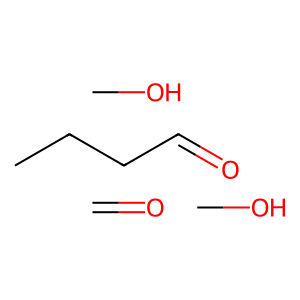

In [52]:

Draw.MolToImage(Chem.MolFromSmiles(n))
# 17 => 93.png

In [279]:
import torch
from MolRep.Featurization.MPNN_embeddings import MolGraph, BatchMolGraph
from rdkit.Chem import MolFromSmiles, rdmolops

def tensors_to_device(smile, batch):
    """Sets nodes, edges, a2b, b2a and adjacency matrix tensors of a molecule to the device"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    adj = rdmolops.GetAdjacencyMatrix(MolFromSmiles(smile))
    
    list = {
        'nodes' : batch.f_atoms, 
        'edges' : batch.f_bonds,
        'a2b' : batch.a2b,
        'b2a' : batch.b2a,
        'adjacency' : torch.FloatTensor(adj) 
    }
    
    for i in list:
        list[i].to(device)
        
    return list['nodes'], list['edges'], list['a2b'], list['b2a'], list['adjacency']

In [280]:
import re
def clean_smile(s:str) -> str:
    """Takes a (fragmented) SMILES as input and returns concatenated valid fragments of it. Does nothing if input is already valid.
    e.g: C.CC.F.O.n.n -> C.CC.F.O
    """
    cs = ""
    # 1. split n/explanations into a list
    subm = s.split('.')
    
    # 2. try to convert the pieces into a molgraph
    # if success, append to a new string cs (cut string)
    for (i, sm) in enumerate(subm): 
        try:
            MolGraph(sm)
            cs += sm
            if i < len(subm) - 1:
                cs += '.'
        except:
            if i < len(subm) - 1:
                cs += '.'
            continue
        
    # remove repetitions and the last period from the string
    cs = re.sub("\.+", ".", cs)
    # ReGeX from https://stackoverflow.com/a/3331982
    cs = re.sub("\.([^.]*)$", "", cs)
    return cs


In [ ]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

EXPERIMENT_MODEL = MODELPATH

In [312]:
def comp_and_suff(i, e = 'IG') :
    """Calculates comprehensiveness and sufficiency for a molecule with index i given explanation e, returns an object with mol_idx, all the smiles (cleaned and uncleaned), predictions for everything, comprehensiveness and sufficiency, and proportion of explanation vs original molecule."""
    
    # TODO move this out so no need to get the same model every time
    
    model = explainer_experiment.get_model(dataset, other={'model_path':EXPERIMENT_MODEL})
    model.eval() # set model to evaluation mode

    smile, explaining_smile, non_explaining_smile, exp_length = split_molecule(i, e)
    
    # clean up the smiles, split may have created invalid molecules
    
    # make a list of 'intact' cleaned smiles 
    clean_smiles = list(map(clean_smile, [smile, explaining_smile, non_explaining_smile]))

    preds = []
    for cs in clean_smiles:
        # if cs is empty, don't predict it
        if cs == "":
            # if no non-explaining, then comp is f(g) = great, because the whole molecule explains the prediction!
            # if no explaining, suff is f(g) = maybe good?, because there's nothing to explain why prediction was made?
            
            # none to begin with != none being valid

            # TODO if explaining/nonexplaining are not empty, add none
            
            # if empty to begin with, 0
            
            preds.append([0])
            continue
            
        subpreds = []
        # fragment here
        splits = cs.split('.')
        for s in splits:
        
            # 3. convert s to molgraph
            try :
                mol = MolGraph(s)
                g_input = BatchMolGraph( [mol])
                atoms, bonds, a2b, b2a, adjacency = tensors_to_device(cs, g_input)
        
                with torch.no_grad():
                    # TODO investigate None params?
                    #   Args for mol2graph:
                    # - mols: A list of SMILES or a list of RDKit molecules.
                    # - atom_descriptors_batch: A list of 2D numpy array containing additional atom descriptors to featurize the molecule
                    subpred = model([[s], None, None]).item()
        
                subpreds.append(subpred)
            except:
                # I don't know why this would happen, but evidently it does happen
                preds.append(None)
        preds.append(subpreds)

    print("preds: ", preds)
    g_pred = preds[0][0] # prediction of original molecule, there is only one
    e_pred = sum(preds[1]) / len(preds[1]) # prediction of explaining molecules - take the mean
    n_pred = sum(preds[2]) # prediction of non-explaining molecules - sum

    # f = model prediction given a smile
    # comp = f(smile) - f(non_explaining_smile)
    # suff = f (smile) - f(explaining_smile)

    comp = g_pred - n_pred if n_pred is not None else None
    suff = g_pred - e_pred if e_pred is not None else None
    
    result = {
        "mol_idx": i,
        "smile" : smile,
        "explaining_smile" : explaining_smile,
        "clean_explanation" : clean_smiles[1],
        "non_explaining_smile" : non_explaining_smile,
        "clean_nonexplanation": clean_smiles[2],
        "mol_pred": g_pred,
        "e_pred": e_pred,
        "ne_pred": n_pred,
        "comp" : comp,
        "suff" : suff,
        "exp length": exp_length
    }

    return result

In [313]:
def comp_and_suff_data(d, attr):
    """Calculates and accumulates the comprehensiveness and sufficiency for all molecules within the test set of the dataset."""
    c_and_s = []

    for i in range(len(d)):
        clear_gpu_memory()
        # only calculate comp and suff for molecules in the test set i.e. which have explanations
        if i in dataset.get_smiles_idxs(testing=True):
            vals = comp_and_suff(i, attr)
            print(vals)
            c_and_s.append(vals)
    return c_and_s

In [283]:
def avg_comp_and_suff(d):
    """Calculates the average comp and suff of a list of data. Returns the original data length, avg comp and suff, and how many samples were used to calculate them."""
    data = pd.DataFrame([d])
    
    c, n, s, m = 0, 0, 0, 0
    
    for i in range(len(d)):
        item = d[i]
        mol_pred = item.get('mol_pred')
        e_pred = item.get('e_pred')
        ne_pred = item.get('ne_pred')
        
        print(i, mol_pred, e_pred, ne_pred)

        if ne_pred is not None:
            # absolute difference between mol prediction and comprehensiveness 
            c += (abs(mol_pred - item.get('comp')) )
            n += 1
        
        if e_pred is not None:
            # absolute value of e_prediction 
            s += abs(item.get('suff'))
            m += 1
        
    # average out the results
    avg_comp = c/n if n != 0 else None
    avg_suff = s/m if m != 0 else None
    
    results = {"original samples" : len(d), 
               "average comp" : avg_comp,
               "average suff" : avg_suff,
               "samples for avg comp" : n,
               "samples for avg suff" : m}
    
    return results

In [284]:

# print(c)

In [315]:
# TODO 2 further work
# save results of comp-suff for transparency
# use a different explainer on the model
# save those results
comps = []
# print(importances_df)
# print(importances_df[importances_df.attribution == 'IG'].Atom_importance.item())
# 
for ATTRIBUTION in ATTRIBUTIONS:
    comp = comp_and_suff_data(importances_df[importances_df.attribution == ATTRIBUTION].Atom_importance.item(), ATTRIBUTION)
    print(comp)
    comps.append(comp)
print(comps)
# print("hi")

Moving model to cuda


UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float32DType'>, <class 'numpy.dtypes.StrDType'>) -> None